### Import Libraries

In [39]:
import gym
import gym.spaces
import numpy as np
import tensorflow as tf
import os
from collections import deque
import random

### Parameters

In [40]:
discount_rate = 0.95
learning_rate = 0.01
hidden_size = 200

### Image Processing

In [41]:
def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else just set to 1
    return np.reshape(image.astype(np.float).ravel(), [80,80])

In [42]:
env = gym.make('Breakout-v0')
env.reset()
print('Environment Reset')

Environment Reset


### Estimator Network

In [47]:
class Network():
    def __init__(self, learning_rate=0.01, hidden_size=10, action_size = 4, memory_size = 3, name="QEstimator"):
        with tf.variable_scope(name):
            # Set scope for copying purposes
            self.scope = name

            # Store Variables
            self.inputs_ = tf.placeholder(tf.float32, [None, memory_size, 80, 80], name='inputs')
            self.target_preds_ = tf.placeholder(tf.float32, [None,], name="expected_future_rewards")
            self.chosen_action_pred = tf.placeholder(tf.float32, [None,], name="chosen_action_pred")
            self.actions_ = tf.placeholder(tf.int32, shape=[None], name='actions')
            self.avg_reward_ = tf.placeholder(tf.float32, name="avg_reward")
            
            # Three Convolutional Layers
            self.conv1 = tf.contrib.layers.conv2d(self.inputs_, 32, 8, 4, activation_fn=tf.nn.relu)
            self.conv2 = tf.contrib.layers.conv2d(self.conv1, 64, 4, 2, activation_fn=tf.nn.relu)
            self.conv3 = tf.contrib.layers.conv2d(self.conv2, 64, 3, 1, activation_fn=tf.nn.relu)

            # Fully Connected Layers
            self.flatten = tf.contrib.layers.flatten(self.conv3)
            self.fc1 = tf.contrib.layers.fully_connected(self.flatten, hidden_size)
            self.predictions = tf.contrib.layers.fully_connected(self.fc1, action_size,
                                                                 weights_initializer=tf.contrib.layers.xavier_initializer(), 
                                                                 activation_fn=None)
            
            # Get Prediction for the chosen action (epsilon greedy)
            self.indices = tf.range(1) * tf.size(self.actions_) + self.actions_
            self.chosen_action_pred = tf.gather(tf.reshape(self.predictions, [-1]), self.indices)
            
            # Calculate Loss
            # self.losses = tf.squared_difference(self.target_preds_, self.chosen_action_pred)
            self.losses = tf.losses.huber_loss(self.target_preds_, self.chosen_action_pred)
            self.loss = tf.reduce_mean(self.losses)
            
            # Adjust Network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.losses)

            # For Tensorboard
            with tf.name_scope("summaries"):
                tf.summary.scalar("loss", self.loss)
                tf.summary.scalar("avg_epoch_reward", self.avg_reward_)
                self.summary_op = tf.summary.merge_all()
            
    def predict(self, sess, state):
        result = sess.run(self.predictions, feed_dict={self.inputs_: state})
        return result
    
    def update(self, sess, state, action, target_preds, avg_reward):
        feed_dict = {self.inputs_: state, 
                    self.actions_: action, 
                    self.target_preds_: target_preds,
                    self.avg_reward_: avg_reward}
        loss = sess.run([self.loss, self.learn, self.summary_op], feed_dict=feed_dict)
        return loss

### Greedy Epsilon Policy
Epsilon greedy policy chooses a random action a small fraction of the time. This epsilon can change throughout training, but this is more advanced.... so hold off on that for now @Self

In [48]:
def epsilon_greedy(sess, network, state, epsilon=0.99):
    state = np.stack([state[0], state[1], state[2]])
    state = np.expand_dims(state, axis=0)
    pick = np.random.rand() # Uniform random number generator
    if pick > epsilon: # If off policy -- random action
        action = np.random.randint(0,4)
    else: # If on policy
        action = np.argmax(network.predict(sess, state))
    return action

### Model Parameter Copier

In [49]:
def copy_parameters(sess, q_network, target_network):
    
    # Get and sort parameters
    q_params = [t for t in tf.trainable_variables() if t.name.startswith(q_network.scope)]
    q_params = sorted(q_params, key=lambda v: v.name)
    t_params = [t for t in tf.trainable_variables() if t.name.startswith(target_network.scope)]
    t_params = sorted(t_params, key=lambda v: v.name)
    
    # Assign Q-Parameters to Target Network
    updates = []
    for q_v, t_v in zip(q_params, t_params):
        update = t_v.assign(q_v)
        updates.append(update)
    
    sess.run(updates)

In [50]:
tf.reset_default_graph()
QNetwork = Network(name = 'QNetwork', hidden_size=hidden_size, learning_rate=learning_rate)
target = Network(name = 'Target', hidden_size=hidden_size, learning_rate=learning_rate)

/Users/sarahgreenwood/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [51]:
# saver = tf.train.Saver()
buffer_size = 500
batch_size = 50
epochs = 10
reset_every = 100
state_memory_size = 3
epsilon_start = 0.1
epsilon_end = 0.99

buffer = deque(maxlen=buffer_size)
state_memory = deque(maxlen=state_memory_size)
all_result = []

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    # Set up count for network reset
    count = 0
    
    # Make epsilon greedy schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epochs)
    
    # Set up memory for episode
    start_state = preprocess(env.reset())
    for fill in range(state_memory_size):
        state_memory.append(start_state)
    
    # Fill The Buffer
    for i in range(buffer_size):
        action = epsilon_greedy(sess, QNetwork, state_memory)
        new_state, reward, done, _ = env.step(action)
        
        # Save old_state_memory
        old_state_memory = state_memory
        
        # Add new_state to state_memory
        state_memory.append(preprocess(new_state))
        
        # Add step to buffer
        buffer.append([old_state_memory, action, state_memory, reward])
        
        # If done, reset memory
        if done: 
            start_state = preprocess(env.reset())
            for fill in range(state_memory_size):
                state_memory.append(start_state)
    
    for epoch in range(epochs):
        
        # Set Up Memory
        start_state = preprocess(env.reset())
        for fill in range(state_memory_size):
            state_memory.append(start_state)

        result = []
        while True: 
            # Add M to buffer (following policy)
            action = epsilon_greedy(sess, QNetwork, state_memory, epsilons[epoch])
            new_state, reward, done, _ = env.step(action)
            
            # Save old_state_memory
            old_state_memory = state_memory
            
            # Add new_state to state_memory 
            state_memory.append(preprocess(new_state))
            
            # Add step to buffer
            buffer.append([old_state_memory, action, state_memory, reward])
            
            # If simulation done, stop
            if done:
                break
            
            ### Sample & update
            sample = random.sample(buffer, batch_size)
            state_b, action_b, new_state_b, reward_b = map(np.array, zip(*sample))

            # Find max Q-Value per batch for progress
            Q_preds = sess.run(QNetwork.chosen_action_pred, 
                                 feed_dict={QNetwork.inputs_: state_b,
                                 QNetwork.actions_: action_b})
            result.append(np.max(Q_preds))
        
            # Target Network Predictions + Discount
            TPredictions = target.predict(sess, new_state_b)
            max_Qt = discount_rate * np.max(TPredictions, axis=1)
            action_Ts = reward_b + max_Qt

            # Update Q-Network
            avg_reward = np.mean(result)
            loss, _, summary = QNetwork.update(sess, state_b, action_b, action_Ts, avg_reward)
            
            # save target network parameters every epoch
            count += 1
            if count % reset_every == 0:
                copy_parameters(sess, QNetwork, target)
        
        all_result.append(np.mean(result))

KeyboardInterrupt: 

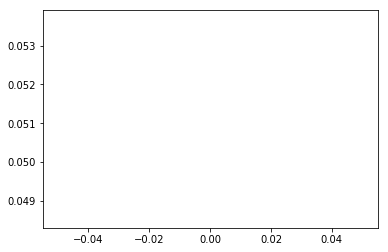

In [52]:
plt.plot(all_result)